In [1]:
import requests
import json
import time
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as  plt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./sample data/Metrics-2.csv')
# df = df.set_index('Time')
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Requests_Sum,10080.0,396.597123,171.827978,49.0,254.0,418.0,525.0,1006.0


In [3]:
date_time = pd.to_datetime(df.pop('Time'), format='%d/%m/%y %H:%M')

In [4]:
print(df.head())
df.shape

   Requests_Sum
0           585
1           706
2           675
3           561
4           735


(10080, 1)

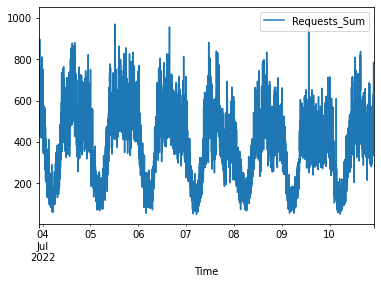

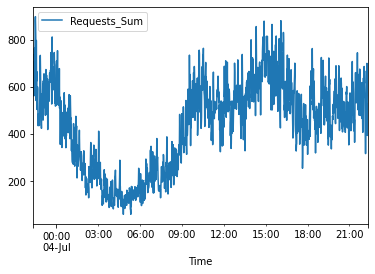

In [5]:
plot_cols = ['Requests_Sum']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)


In [6]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
print(timestamp_s[0])
print(timestamp_s[1])


1656886800.0
1656886860.0


tf.Tensor(
[ 3.9983885e+06+1.2686157e+00j  4.5525855e+04-2.0228975e+05j
 -3.9444941e+04-2.2899719e+04j ... -2.1438286e+03-4.5022500e+03j
 -2.6195395e+02+1.6288335e+03j  4.9991992e+03-1.3443604e+00j], shape=(5041,), dtype=complex64)
[   0    1    2 ... 5038 5039 5040]
7.0
[0.00000000e+00 1.42857143e-01 2.85714286e-01 ... 7.19714286e+02
 7.19857143e+02 7.20000000e+02]


array([3.9983885e+06, 2.0734933e+05, 4.5610312e+04, ..., 4.9866079e+03,
       1.6497632e+03, 4.9991992e+03], dtype=float32)

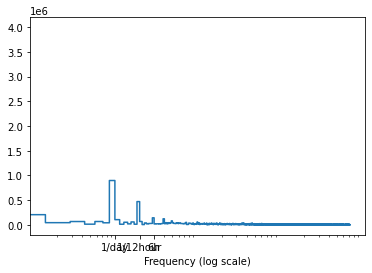

In [118]:
fft = tf.signal.rfft(df['Requests_Sum'])
print(fft)
f_per_dataset = np.arange(0,len(fft))
print(f_per_dataset)
n_samples_m = len(df['Requests_Sum'])
minutes_per_day = 60*24
days_per_dataset = n_samples_m/(minutes_per_day)
print(days_per_dataset)
f_per_day = f_per_dataset/days_per_dataset
print(f_per_day)
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 1)
# plt.xlim([0.001, max(plt.xlim())])
plt.xticks([1, 2,3], labels=['1/day', '1/12hour','6h'])
_ = plt.xlabel('Frequency (log scale)')
np.abs(fft)

In [8]:
hour = 3600
day = 86400
half_day = int(day/2)

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df['Half Day sin'] = np.sin(timestamp_s * (2 * np.pi / half_day))
df['Half Day cos'] = np.cos(timestamp_s * (2 * np.pi / half_day))

Text(0.5, 1.0, 'Time of day signal')

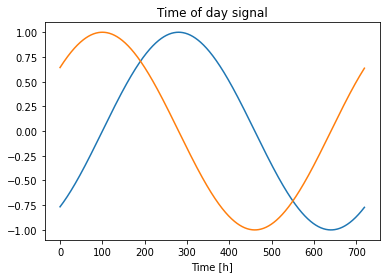

In [9]:
plt.plot(np.array(df['Half Day sin'])[:720])
plt.plot(np.array(df['Half Day cos'])[:720])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
print(n)
print(train_df.head())
num_features = df.shape[1]
print("no. of features: ",num_features)

10080
   Requests_Sum   Day sin   Day cos  Hour sin  Hour cos  Half Day sin  \
0           585 -0.422618  0.906308  0.866025 -0.500000     -0.766044   
1           706 -0.418660  0.908143  0.809017 -0.587785     -0.760406   
2           675 -0.414693  0.909961  0.743145 -0.669131     -0.754710   
3           561 -0.410719  0.911762  0.669131 -0.743145     -0.748956   
4           735 -0.406737  0.913545  0.587785 -0.809017     -0.743145   

   Half Day cos  
0      0.642788  
1      0.649448  
2      0.656059  
3      0.662620  
4      0.669131  
no. of features:  7


In [11]:
# Normalize the data

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.head()

,Requests_Sum,Day sin,Day cos,Hour sin,Hour cos,Half Day sin,Half Day cos
0,1.001539,-0.616766,1.303435,1.227237,-0.704484,-1.119226,0.903847
1,1.682142,-0.611171,1.306032,1.146621,-0.828622,-1.111188,0.913195
2,1.507773,-0.605564,1.308605,1.053470,-0.943654,-1.103067,0.922473
3,0.866543,-0.599947,1.311154,0.948805,-1.048319,-1.094864,0.931680
4,1.845262,-0.594318,1.313678,0.833773,-1.141470,-1.086580,0.940817


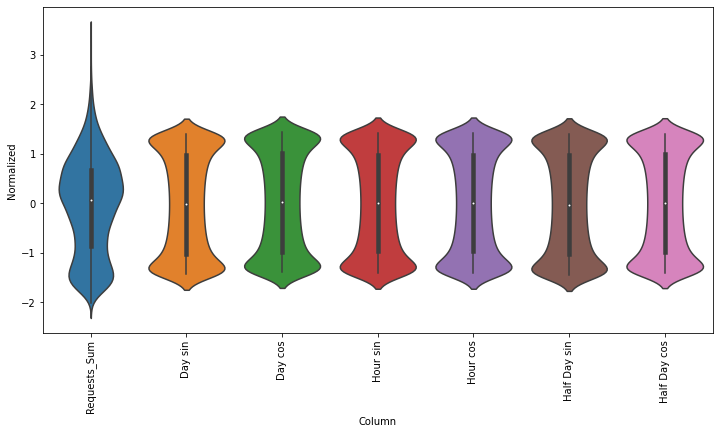

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [53]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
      return inputs, labels
  def plot(self, model=None, plot_col='Requests_Sum', max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time [m]')

In [54]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Requests_Sum'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Requests_Sum']

In [55]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Requests_Sum'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Requests_Sum']

In [56]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [57]:
w2.example = example_inputs, example_labels

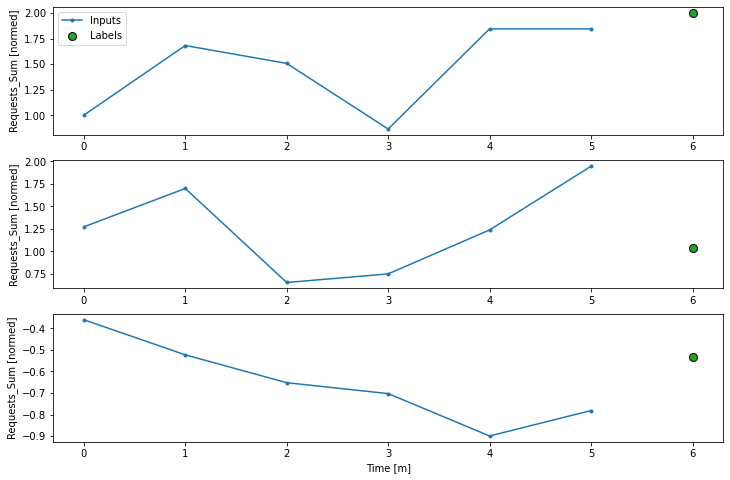

In [58]:
w2.plot()

In [59]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [60]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [61]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [62]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [63]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Requests_Sum'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Requests_Sum']

In [64]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [65]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [66]:
baseline = Baseline(label_index=column_indices['Requests_Sum'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 669us/step - loss: 0.1530 - mean_absolute_error: 0.2931


In [105]:
wide_window = WindowGenerator(
    input_width=720, label_width=720, shift=1,
    label_columns=['Requests_Sum'])

wide_window

Total window size: 721
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [68]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


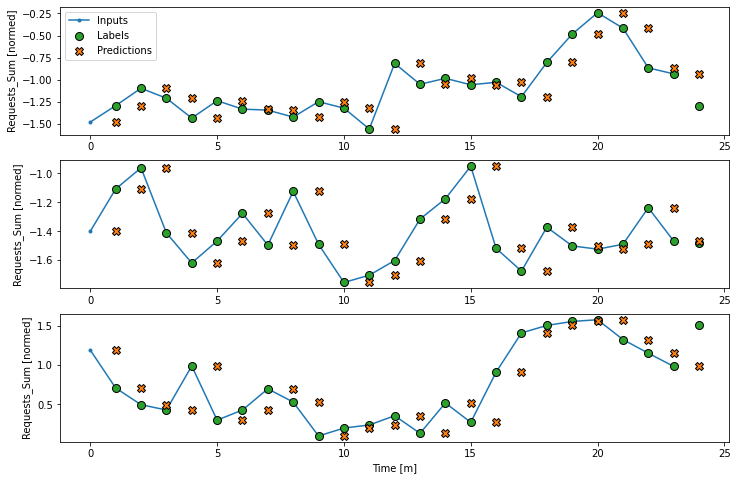

In [69]:
wide_window.plot(baseline)

In [70]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [71]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [72]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [73]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 1ms/step - loss: 1.5272 - mean_absolute_error: 1.0005 - val_loss: 0.9998 - val_mean_absolute_error: 0.8085
Epoch 2/20
221/221 [==============================] - 0s 995us/step - loss: 0.7709 - mean_absolute_error: 0.7089 - val_loss: 0.5126 - val_mean_absolute_error: 0.5765
Epoch 3/20
221/221 [==============================] - 0s 1ms/step - loss: 0.4248 - mean_absolute_error: 0.5217 - val_loss: 0.2945 - val_mean_absolute_error: 0.4350
Epoch 4/20
221/221 [==============================] - 0s 1ms/step - loss: 0.2700 - mean_absolute_error: 0.4110 - val_loss: 0.2019 - val_mean_absolute_error: 0.3544
Epoch 5/20
221/221 [==============================] - 0s 1ms/step - loss: 0.2036 - mean_absolute_error: 0.3524 - val_loss: 0.1639 - val_mean_absolute_error: 0.3145
Epoch 6/20
221/221 [==============================] - 0s 1ms/step - loss: 0.1761 - mean_absolute_error: 0.3245 - val_loss: 0.1486 - val_mean_absolute_error: 0.2963
Epoch 7/20
221

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


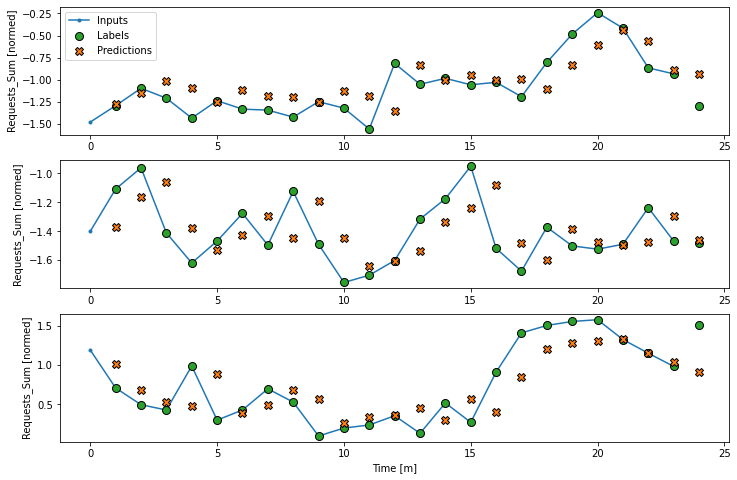

In [75]:
wide_window.plot(linear)

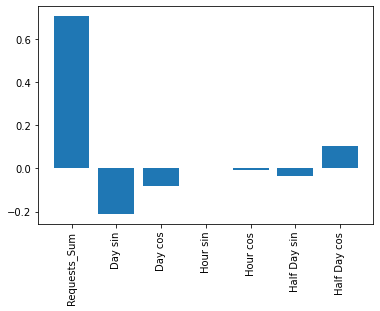

In [76]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [77]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window,patience=4)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 2ms/step - loss: 0.1984 - mean_absolute_error: 0.3415 - val_loss: 0.1335 - val_mean_absolute_error: 0.2773
Epoch 2/20
221/221 [==============================] - 0s 1ms/step - loss: 0.1554 - mean_absolute_error: 0.3047 - val_loss: 0.1386 - val_mean_absolute_error: 0.2778
Epoch 3/20
221/221 [==============================] - 0s 1ms/step - loss: 0.1545 - mean_absolute_error: 0.3041 - val_loss: 0.1468 - val_mean_absolute_error: 0.2914
Epoch 4/20
221/221 [==============================] - 0s 1ms/step - loss: 0.1528 - mean_absolute_error: 0.3019 - val_loss: 0.1459 - val_mean_absolute_error: 0.2855
Epoch 5/20
63/63 [==============================] - 0s 760us/step - loss: 0.1379 - mean_absolute_error: 0.2815


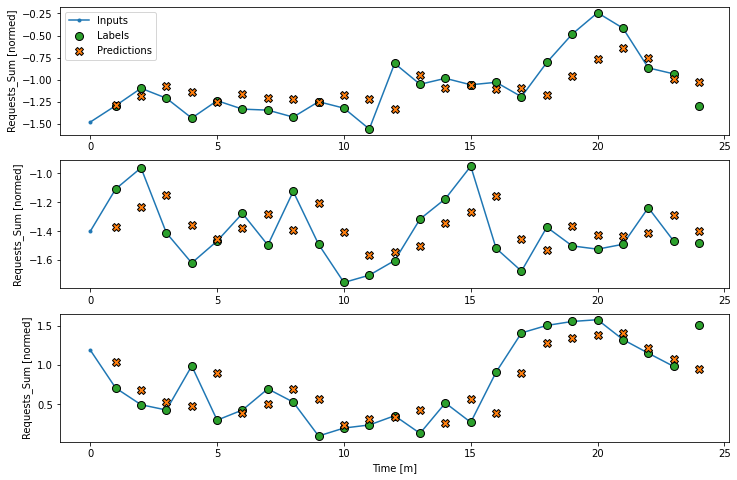

In [78]:
wide_window.plot(dense)

In [79]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Requests_Sum'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Requests_Sum']

Text(0.5, 1.0, 'Given 3 minutes of inputs, predict 1 minute into the future.')

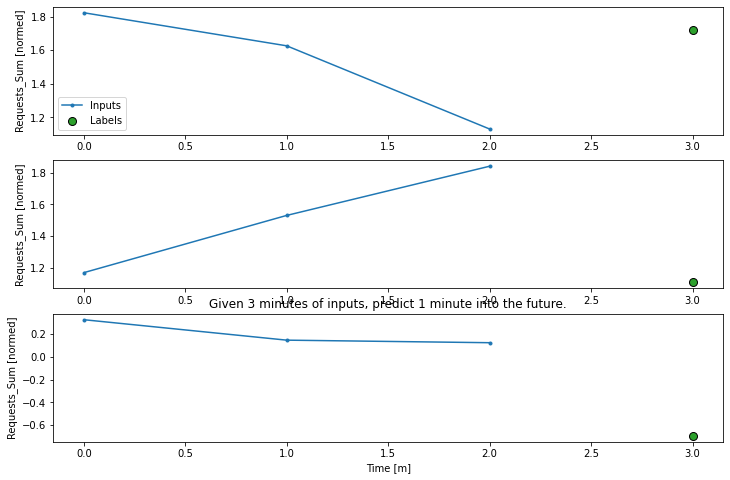

In [80]:
conv_window.plot()
plt.title("Given 3 minutes of inputs, predict 1 minute into the future.")

In [81]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [82]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [84]:
history = compile_and_fit(multi_step_dense, conv_window)
import IPython
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 702us/step - loss: 0.1375 - mean_absolute_error: 0.2772


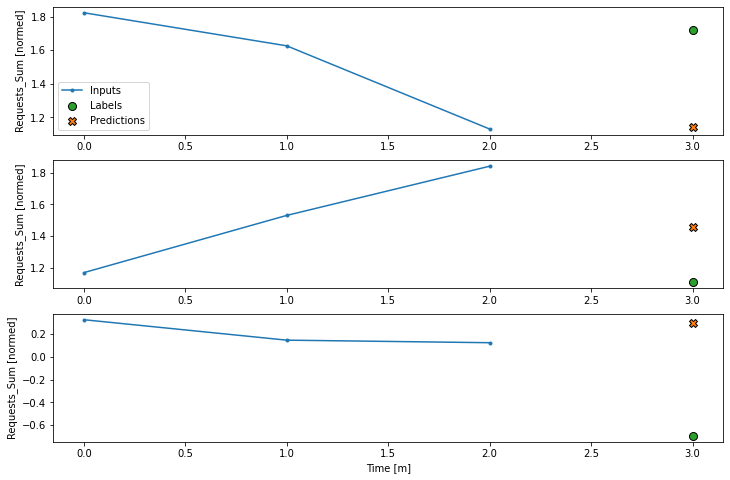

In [85]:
conv_window.plot(multi_step_dense)

In [86]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 7)

ValueError:Exception encountered when calling layer "sequential_6" (type Sequential).

Input 0 of layer "dense_14" is incompatible with the layer: expected axis -1 of input shape to have value 21, but received input with shape (32, 168)

Call arguments received by layer "sequential_6" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 7), dtype=float32)
  • training=None
  • mask=None


In [87]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [88]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [89]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 704us/step - loss: 0.1343 - mean_absolute_error: 0.2753


In [90]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [98]:
LABEL_WIDTH = 60
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Requests_Sum'])

wide_conv_window

Total window size: 63
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]
Label column name(s): ['Requests_Sum']

In [99]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 62, 7)
Labels shape: (32, 60, 1)
Output shape: (32, 60, 1)


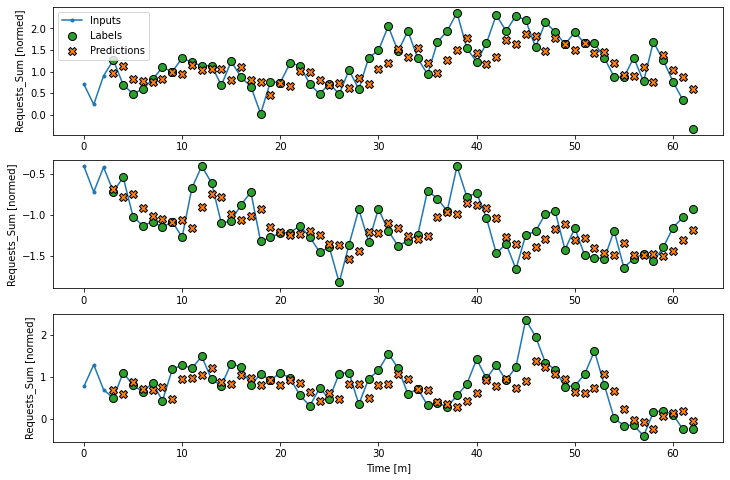

In [100]:
wide_conv_window.plot(conv_model)

In [101]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [102]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


In [106]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

41/41 [==============================] - 1s 31ms/step - loss: 0.2054 - mean_absolute_error: 0.3366


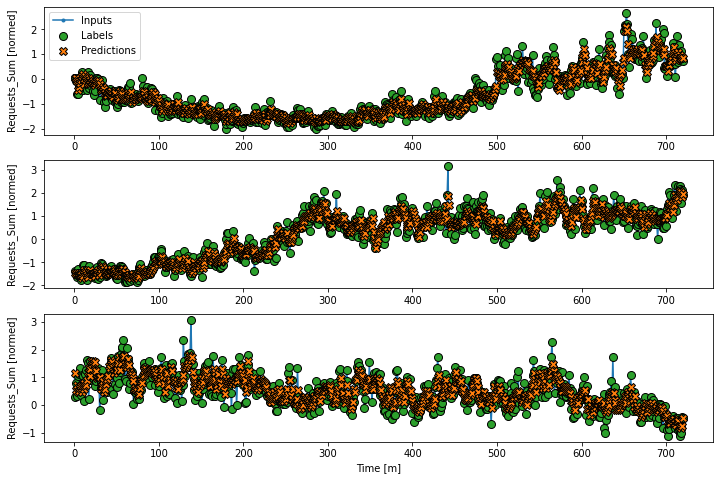

In [107]:
wide_window.plot(lstm_model)

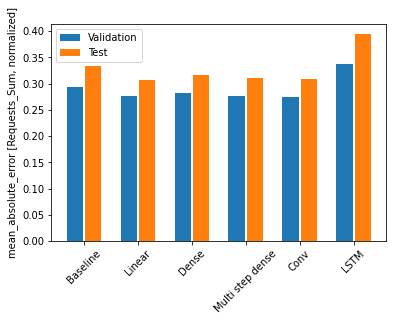

In [109]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Requests_Sum, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [110]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)


In [111]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

63/63 [==============================] - 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.0493

CPU times: user 54.2 s, sys: 9.92 s, total: 1min 4s
Wall time: 28.2 s


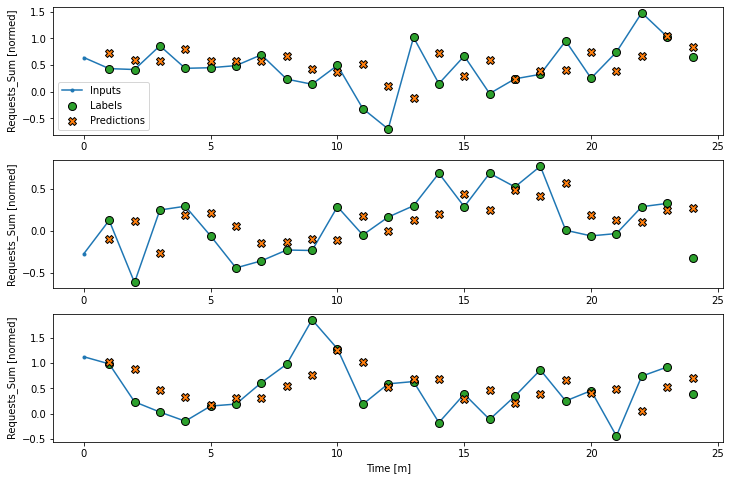

In [112]:
wide_window.plot(lstm_model)

Total window size: 1440
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

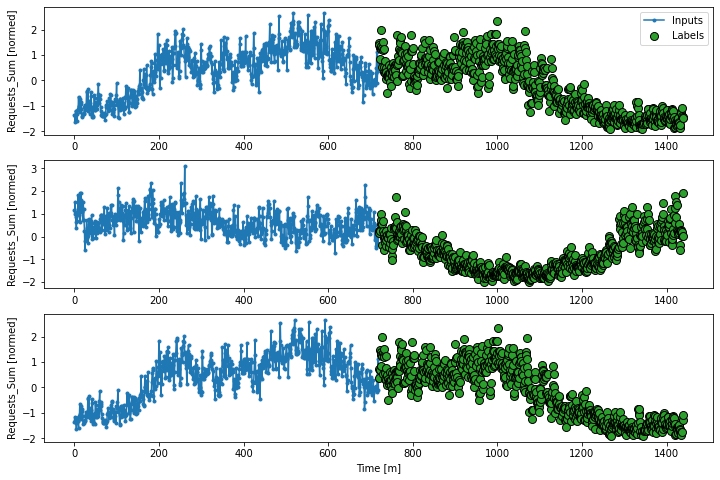

In [114]:
OUT_STEPS = 720
multi_window = WindowGenerator(input_width=720,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

19/19 [==============================] - 0s 2ms/step - loss: 1.8091 - mean_absolute_error: 1.0741


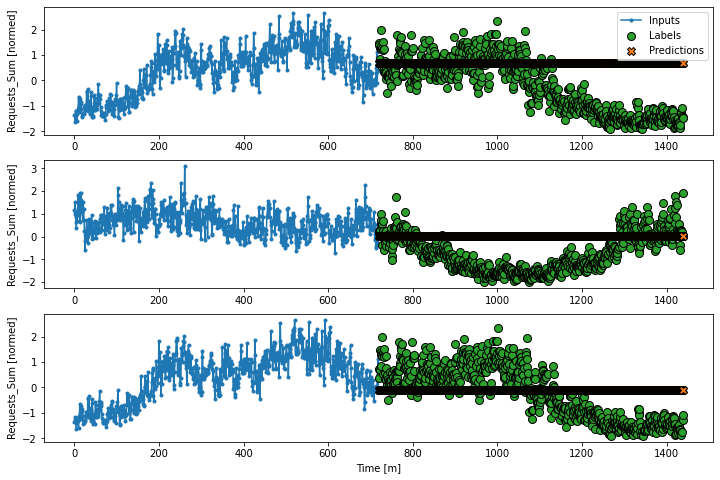

In [115]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

19/19 [==============================] - 0s 2ms/step - loss: 1.3936 - mean_absolute_error: 0.6754


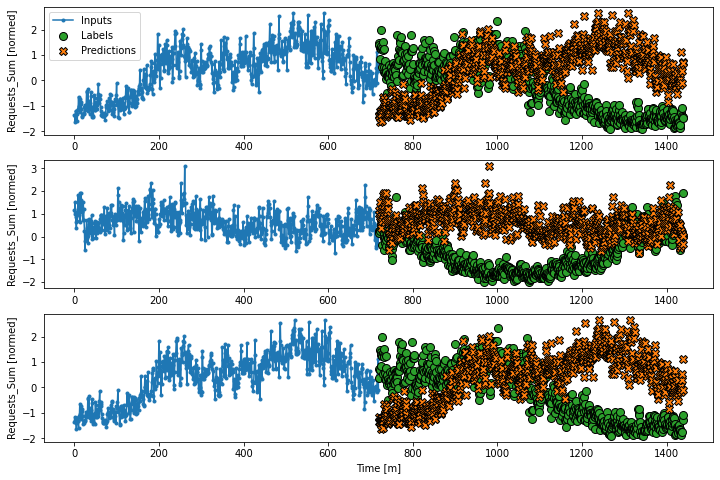

In [116]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

19/19 [==============================] - 1s 34ms/step - loss: 0.0595 - mean_absolute_error: 0.1057


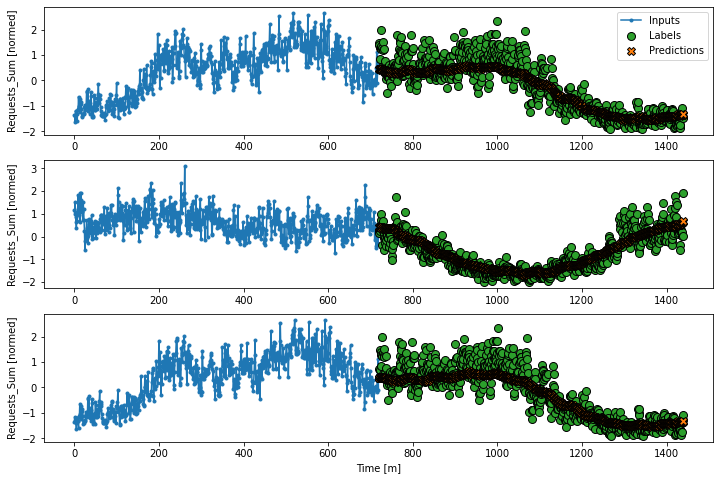

In [117]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)